In [1]:
from PIL import Image

In [2]:
import xarray as xr
from xnoah.xarray import coarsen
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm_notebook as tqdm
import dask.bag as db
from dask.diagnostics import ProgressBar
import os, re



path="/home/disk/eos13/guest/SAM6.10.6_NG/OUT_2D"
file="NG_5120x2560x34_4km_10s_QOBS_EQX_1280_0000858600.2Dcom_001.nc"

! mkdir -p frames


def make_image(args):
    k, file = args
    
    f = xr.open_dataset(file, cache=False)
    i = int(f.time * 84000)
    filename = "frames/%05d.png"%k
    
    if not os.path.exists(filename):
        img = f.CLD.coarsen(x=4, y=4).values
        cmap = plt.get_cmap('bone')
        bits = np.uint8(cmap(img[0,...]/100)*255)
        im = Image.fromarray(bits)
        im.save(filename)
        
    return filename


In [5]:
pattern = "/home/disk/eos13/guest/SAM6.10.6_NG/OUT_2D/NG_5120x2560x34_4km_10s_QOBS_EQX_1280_*.nc"
files = enumerate(sorted(glob(pattern)))

In [6]:
ims = db.from_sequence(files).map(make_image)
ims = ims.compute(num_workers=16)

In [11]:
!ffmpeg  -y -r 30 -f image2 -s 1280x600 -i frames/%05d.png -vcodec libx264 -crf 26  -pix_fmt yuv420p test.mp4

ffmpeg version 2.6.8 Copyright (c) 2000-2016 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-4)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --enable-bzlib --disable-crystalhd --enable-gnutls --enable-ladspa --enable-libass --enable-libcdio --enable-libdc1394 --enable-libfaac --enable-nonfree --enable-libfdk-aac --enable-nonfree --disable-indev=jack --enable-libfreetype --enable-libgsm --enable-libmp3lame --enable-openal --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-libschroedinger --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libv4l2 --enable-libx264 --enable-libx265 --enable-libxvid --enable-x11grab --enable-avfilter --enable-a

# Coarse-graining plot

In [23]:
%matplotlib inline

In [13]:
ds = xr.open_dataset(path+"/"+ file)

In [15]:
len(ds.y)/2

1280.0

In [27]:
box = dict(x=slice(0, 40*20), y=slice(1280-10*40, 1280+10*40))

ds_box = ds.isel(**box).squeeze()
ds_box['x'] /= 1e3
ds_box['y'] /= 1e3

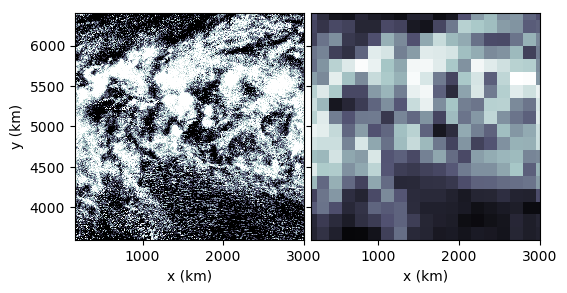

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True, dpi=100)
plt.subplots_adjust(wspace=0.03)

z = ds_box.CLD
axs[0].pcolormesh(z.x, z.y, z, cmap='bone')

zc = coarsen(z, x=40, y=40)
axs[1].pcolormesh(zc.x, zc.y, zc, cmap='bone')
axs[0].set_xlim([160, 3000])
axs[0].set_ylim([3600, 6400])


for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')